In [1]:
from tensorflow import keras

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import pandas as pd
import matplotlib.pyplot as plt

import numpy as np

In [2]:
housing = fetch_california_housing()

In [3]:
pd.DataFrame(columns=housing.feature_names, data=housing.data)

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25
...,...,...,...,...,...,...,...,...
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32


In [4]:
# get train, val, and test data sets
X_train_full, X_test, y_train_full, y_test = train_test_split(housing.data, housing.target)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full)

# apply transformation to all X_ data sets
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

# Use a simple NN Architecture for Example

In [ ]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=X_train.shape[1:]),
    keras.layers.Dense(1)
])
weights = model.get_weights()

model.set_weights(weights)
model.compile(loss="mean_squared_error", optimizer="sgd")

history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))

In [ ]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.show()

# Building Complex Models using the Functional API

## Wide & Deep Model

*Learn simple rules (wide) and complex (deep) by cononecting the input to the output in addition to having your standard deep neural network architecture.*

In [ ]:
input_ = keras.layers.Input(shape=X_train.shape[1:])
hidden1 = keras.layers.Dense(30, activation="relu")(input_)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)
concat = keras.layers.Concatenate()([input_, hidden2])
output = keras.layers.Dense(1)(concat)
model = keras.Model(inputs=[input_], outputs=[output])

weights = model.get_weights() # save initialized weights of model for model re-training

In [ ]:
model.set_weights(weights) # reset weights so that we start training fresh

# setup learning rate schedule 
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=10000,
    decay_rate=0.9)
optimizer = keras.optimizers.SGD(learning_rate=lr_schedule)
# optimizer = keras.optimizers.SGD(lr=1e-3)

model.compile(loss="mean_squared_error", optimizer=optimizer)

history = model.fit(X_train, y_train, epochs=30, validation_data=(X_valid, y_valid), )

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
#plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

## Multi-Input Model

In [ ]:
input_A = keras.layers.Input(shape=[5], name="wide_input")
input_B = keras.layers.Input(shape=[6], name="deep_input")
hidden1 = keras.layers.Dense(30, activation="relu")(input_B)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)
concat = keras.layers.concatenate([input_A, hidden2])
output = keras.layers.Dense(1, name="output")(concat)
model = keras.Model(inputs=[input_A, input_B], outputs=[output])

weights = model.get_weights() # save initialized weights of model for model re-training

model.set_weights(weights) # reset weights so that we start training fresh

# setup learning rate 
optimizer = keras.optimizers.SGD(learning_rate=1e-3)

#model.compile(loss="mean_squared_error", optimizer='sgd')
model.compile(loss="mean_squared_error", optimizer=optimizer)

X_train_A, X_train_B = X_train[:, :5], X_train[:, 2:]
X_valid_A, X_valid_B = X_valid[:, :5], X_valid[:, 2:]
X_test_A, X_test_B = X_test[:, :5], X_test[:, 2:]
X_new_A, X_new_B = X_test_A[:3], X_test_B[:3]

history = model.fit((X_train_A, X_train_B), y_train, epochs=20, validation_data=((X_valid_A, X_valid_B), y_valid))
# mse_test = model.evaluate((X_test_A, X_test_B), y_test)
# y_pred = model.predict((X_new_A, X_new_B))

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
#plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

## Multi-Output Model

There are many use cases in which you may want to have multiple outputs:<br>
• You may want to predict multiple things with the same network - if an NFT sold and how much it sold for. <br>
• You may have multiple independent tasks based on the same data. Sure,
you could train one neural network per task, but in many cases you will get better
results on all tasks by training a single neural network with one output per task.
This is because the neural network can learn features in the data that are useful
across tasks. For example, you could perform multitask classification on pictures
of faces, using one output to classify the person’s facial expression (smiling, surprised,
etc.) and another output to identify whether they are wearing glasses or
not.<br>
• Another use case is as a regularization technique (i.e., a training constraint whose
objective is to reduce overfitting and thus improve the model’s ability to generalize).
For example, you may want to add some auxiliary outputs in a neural network
architecture (see Figure 10-16) to ensure that the underlying part of the
network learns something useful on its own, without relying on the rest of the
network.

In [ ]:
input_A = keras.layers.Input(shape=[5], name="wide_input")
input_B = keras.layers.Input(shape=[6], name="deep_input")
hidden1 = keras.layers.Dense(30, activation="relu")(input_B)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)
concat = keras.layers.concatenate([input_A, hidden2])
output = keras.layers.Dense(1, name="main_output")(concat)
aux_output = keras.layers.Dense(1, name="aux_output")(hidden2)
model = keras.Model(inputs=[input_A, input_B], outputs=[output, aux_output])

weights = model.get_weights() # save initialized weights of model for model re-training

model.set_weights(weights) # reset weights so that we start training fresh

# setup learning rate 
optimizer = keras.optimizers.SGD(learning_rate=1e-3)

#model.compile(loss="mean_squared_error", optimizer='sgd')
model.compile(loss=["mse", "mse"], loss_weights=[0.9, 0.1], optimizer="sgd")

X_train_A, X_train_B = X_train[:, :5], X_train[:, 2:]
X_valid_A, X_valid_B = X_valid[:, :5], X_valid[:, 2:]
X_test_A, X_test_B = X_test[:, :5], X_test[:, 2:]
X_new_A, X_new_B = X_test_A[:3], X_test_B[:3]

history = model.fit(
    [X_train_A, X_train_B], [y_train, y_train], 
    epochs=20, 
    validation_data=([X_valid_A, X_valid_B], [y_valid, y_valid])
)


pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
#plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

## Save a Model

In [ ]:
# model.save("my_keras_model.h5")

In [ ]:
# model = keras.models.load_model("my_keras_model.h5")

# Callbacks

*The fit() method accepts a callbacks argument that lets you specify a list of objects
that Keras will call at the start and end of training, at the start and end of each epoch,
and even before and after processing each batch.*

*The number of epochs can be set to a large value since training will stop automatically
when there is no more progress. In this case, there is no need to restore the best
model saved because the EarlyStopping callback will keep track of the best weights
and restore them for you at the end of training.*

In [7]:
# create model architecture
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=X_train.shape[1:]),
    keras.layers.Dense(1)
])
weights = model.get_weights()

# reset weights
model.set_weights(weights)

# compile model
model.compile(loss="mse", optimizer = keras.optimizers.SGD(learning_rate=1e-3))

# setup callbacks
checkpoint_cb = keras.callbacks.ModelCheckpoint("my_keras_model.h5", save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

# fit model
history = model.fit(
    X_train, 
    y_train, 
    epochs=250,
    validation_data=(X_valid, y_valid),
    callbacks=[checkpoint_cb, early_stopping_cb]
)

Epoch 1/250
363/363 [==============================] - 0s 1ms/step - loss: 2.2517 - val_loss: 0.8774
Epoch 2/250
363/363 [==============================] - 0s 881us/step - loss: 0.7474 - val_loss: 0.6698
Epoch 3/250
363/363 [==============================] - 0s 1ms/step - loss: 0.6397 - val_loss: 0.6342
Epoch 4/250
363/363 [==============================] - 0s 886us/step - loss: 0.6090 - val_loss: 0.6112
Epoch 5/250
363/363 [==============================] - 0s 903us/step - loss: 0.5867 - val_loss: 0.5917
Epoch 6/250
363/363 [==============================] - 0s 907us/step - loss: 0.5685 - val_loss: 0.5751
Epoch 7/250
363/363 [==============================] - 0s 878us/step - loss: 0.5520 - val_loss: 0.5596
Epoch 8/250
363/363 [==============================] - 0s 882us/step - loss: 0.5385 - val_loss: 0.5461
Epoch 9/250
363/363 [==============================] - 0s 879us/step - loss: 0.5265 - val_loss: 0.5335
Epoch 10/250
363/363 [==============================] - 0s 925us/step - loss:

Epoch 80/250
363/363 [==============================] - 0s 931us/step - loss: 0.3938 - val_loss: 0.4063
Epoch 81/250
363/363 [==============================] - 0s 842us/step - loss: 0.3931 - val_loss: 0.4057
Epoch 82/250
363/363 [==============================] - 0s 876us/step - loss: 0.3925 - val_loss: 0.4051
Epoch 83/250
363/363 [==============================] - 0s 1ms/step - loss: 0.3920 - val_loss: 0.4046
Epoch 84/250
363/363 [==============================] - 0s 1ms/step - loss: 0.3915 - val_loss: 0.4043
Epoch 85/250
363/363 [==============================] - 0s 870us/step - loss: 0.3909 - val_loss: 0.4034
Epoch 86/250
363/363 [==============================] - 0s 854us/step - loss: 0.3904 - val_loss: 0.4032
Epoch 87/250
363/363 [==============================] - 0s 867us/step - loss: 0.3898 - val_loss: 0.4023
Epoch 88/250
363/363 [==============================] - 0s 840us/step - loss: 0.3892 - val_loss: 0.4021
Epoch 89/250
363/363 [==============================] - 0s 854us/ste

363/363 [==============================] - 0s 1ms/step - loss: 0.3642 - val_loss: 0.3762
Epoch 159/250
363/363 [==============================] - 0s 856us/step - loss: 0.3640 - val_loss: 0.3761
Epoch 160/250
363/363 [==============================] - 0s 904us/step - loss: 0.3635 - val_loss: 0.3757
Epoch 161/250
363/363 [==============================] - 0s 898us/step - loss: 0.3637 - val_loss: 0.3755
Epoch 162/250
363/363 [==============================] - 0s 848us/step - loss: 0.3630 - val_loss: 0.3756
Epoch 163/250
363/363 [==============================] - 0s 915us/step - loss: 0.3631 - val_loss: 0.3750
Epoch 164/250
363/363 [==============================] - 0s 863us/step - loss: 0.3626 - val_loss: 0.3759
Epoch 165/250
363/363 [==============================] - 0s 853us/step - loss: 0.3626 - val_loss: 0.3746
Epoch 166/250
363/363 [==============================] - 0s 870us/step - loss: 0.3622 - val_loss: 0.3746
Epoch 167/250
363/363 [==============================] - 0s 934us/step 

363/363 [==============================] - 0s 808us/step - loss: 0.3474 - val_loss: 0.3619
Epoch 237/250
363/363 [==============================] - 0s 829us/step - loss: 0.3472 - val_loss: 0.3619
Epoch 238/250
363/363 [==============================] - 0s 805us/step - loss: 0.3472 - val_loss: 0.3614
Epoch 239/250
363/363 [==============================] - 0s 813us/step - loss: 0.3471 - val_loss: 0.3610
Epoch 240/250
363/363 [==============================] - 0s 834us/step - loss: 0.3467 - val_loss: 0.3605
Epoch 241/250
363/363 [==============================] - 0s 856us/step - loss: 0.3469 - val_loss: 0.3610
Epoch 242/250
363/363 [==============================] - 0s 846us/step - loss: 0.3464 - val_loss: 0.3607
Epoch 243/250
363/363 [==============================] - 0s 865us/step - loss: 0.3461 - val_loss: 0.3604
Epoch 244/250
363/363 [==============================] - 0s 817us/step - loss: 0.3460 - val_loss: 0.3607
Epoch 245/250
363/363 [==============================] - 0s 838us/ste

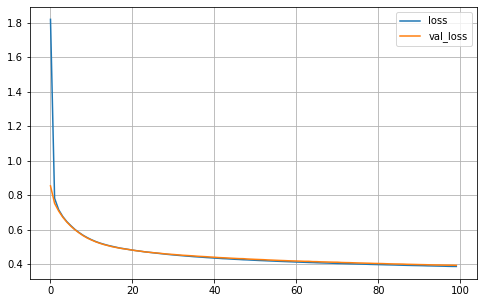

In [6]:

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
#plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

# Fine-Tuning Neural Network Hyperparameters

## Number of Hidden Layers

*For many problems, you can begin with a single hidden layer and get reasonable
results. An MLP with just one hidden layer can theoretically model even the most
complex functions, provided it has enough neurons. But for complex problems, deep
networks have a much higher parameter efficiency than shallow ones: they can model
complex functions using exponentially fewer neurons than shallow nets, allowing
them to reach much better performance with the same amount of training data.*

*lower hidden layers model low-level structures (e.g., line segments of various
shapes and orientations), intermediate hidden layers combine these low-level
structures to model intermediate-level structures (e.g., squares, circles), and the highest
hidden layers and the output layer combine these intermediate structures to
model high-level structures (e.g., faces).*

*Not only does this hierarchical architecture help DNNs converge faster to a good solution,
but it also improves their ability to generalize to new datasets. For example, if
you have already trained a model to recognize faces in pictures and you now want to
train a new neural network to recognize hairstyles, you can kickstart the training by
reusing the lower layers of the first network. Instead of randomly initializing the
weights and biases of the first few layers of the new neural network, you can initialize
them to the values of the weights and biases of the lower layers of the first network.
This way the network will not have to learn from scratch all the low-level structures
that occur in most pictures; it will only have to learn the higher-level structures (e.g.,
hairstyles). This is called transfer learning.*